In [1]:
import os
import sys
import yaml
import dask
import zarr
import numpy as np
import xesmf as xe
import xarray as xr
import pandas as pd
from glob import glob
# from dask.utils import SerializableLock

# import calendar
from datetime import datetime, timedelta
# from dateutil.relativedelta import relativedelta

# sys.path.insert(0, os.path.realpath('../libs/'))
# import verif_utils as vu

In [2]:
import pygrib

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
# 1000.,  950.,  850.,  700.,  600.,  500.,  400.,  300.,  200.,  100., 50.

In [5]:
eps = 0.62198  # Rd/Rv

def es_bolton_hPa(Tk: xr.DataArray) -> xr.DataArray:
    """Saturation vapor pressure (hPa). Water for T>=0C, ice for T<0C."""
    Tc = Tk - 273.15
    # Bolton (1980) style forms commonly used:
    es_w = 6.112 * np.exp(17.67 * Tc / (Tc + 243.5))     # over liquid water
    es_i = 6.112 * np.exp(22.46 * Tc / (Tc + 272.62))    # over ice
    return xr.where(Tk >= 273.15, es_w, es_i)

def rh_to_q(RH: xr.DataArray, T: xr.DataArray, p_level: xr.DataArray) -> xr.DataArray:
    """Convert RH + T + pressure to specific humidity q (kg/kg)."""
    # RH to fraction
    RH_frac = xr.where(RH.max() > 2.0, RH / 100.0, RH)
    RH_frac = RH_frac.clip(0.0, 1.0)

    # Pressure to hPa (auto-detect units by magnitude)
    p_hPa = p_level #xr.where(p_level.mean() > 2000.0, p_level / 100.0, p_level)

    # Saturation vapor pressure (hPa) and actual vapor pressure (hPa)
    es = es_bolton_hPa(T)
    e = RH_frac * es

    # Specific humidity (direct form; units consistent in hPa)
    q = (eps * e) / (p_hPa - (1.0 - eps) * e)
    q.name = "Q"
    q.attrs.update({
        "long_name": "specific_humidity",
        "units": "kg kg-1",
        "description": "Computed from RH and T on pressure levels using Bolton(1980) es with water/ice switch."
    })
    return q

In [6]:
# C404 static
static_WRF_name = '/glade/derecho/scratch/ksha/DWC_data/CONUS_domain_GP/static/C404_GP_static.zarr'
ds_WRF_static = xr.open_zarr(static_WRF_name)
XLAT = ds_WRF_static['XLAT'].values
XLONG = ds_WRF_static['XLONG'].values
ds_WRF_static = ds_WRF_static.assign_coords(lat=(("south_north", "west_east"), XLAT))
ds_WRF_static = ds_WRF_static.assign_coords(lon=(("south_north", "west_east"), XLONG))
domain_inds = np.arange(336).astype(np.float32)

* Precipitable water:kg m**-2 (instant):regular_ll:atmosphereSingleLayer:level 0 considered as a single layer
* Precipitation rate:kg m**-2 s**-1 (instant):regular_ll:surface:level 0:fcst time 0 hrs:from 202412311800

In [7]:
# # Check grib2 variables

# grbs = pygrib.open(fn_list[-1])
# for grb in grbs:
#     print(grb)

In [23]:
levels_hPa = [1000, 950, 850, 700, 600, 500, 400, 300, 200, 100, 50]
levels_Pa = np.array(levels_hPa, dtype=np.int32) * 100  # Pa

want_isobaric = {
    "U component of wind": "U",
    "V component of wind": "V",
    "Temperature": "T",
    "Relative humidity": "RH",
}
want_surface = {
    ("Pressure reduced to MSL", "meanSea", 0): "MSL",
    ("10 metre U wind component", "heightAboveGround", 10): "VAR_10U",
    ("10 metre V wind component", "heightAboveGround", 10): "VAR_10V",
    ("2 metre temperature", "heightAboveGround", 2): "VAR_2T",
    ("Precipitable water", "atmosphereSingleLayer", 0): "GDAS_PWAT",
    ("Precipitation rate", "surface", 0): "GDAS_APCP",
}

In [24]:
year = 2024
base_dir = "/gdex/data/d083002/grib2/"

In [25]:
start = datetime(year, 1, 1)
end = datetime(year, 12, 31, 18)
dt_list = [start + i*timedelta(hours=6) for i in range(((end-start)//timedelta(hours=6)) + 1)]

fn_list = []
for dt in dt_list:
    month_dir = f"{year}.{dt:%m}"
    filename = dt.strftime("fnl_%Y%m%d_%H_%M.grib2")
    fn_list.append(os.path.join(base_dir, str(year), month_dir, filename))

In [27]:
ds_collection = []
N_ = 50

for i_fn, fn in enumerate(fn_list[:N_]):
    grbs = pygrib.open(fn)
    
    # Peek first grib that has a grid to get lat/lon shape
    # (Some messages may be spectral, but FNL/analyses are usually on regular_ll)
    sample = grbs.message(1)
    lats, lons = sample.latlons()
    ny, nx = lats.shape
    
    # Preallocate arrays
    iso_shape = (len(levels_Pa), ny, nx)
    U = np.full(iso_shape, np.nan, dtype=np.float32)
    V = np.full(iso_shape, np.nan, dtype=np.float32)
    T = np.full(iso_shape, np.nan, dtype=np.float32)
    RH = np.full(iso_shape, np.nan, dtype=np.float32)
    
    MSLP = np.full((ny, nx), np.nan, dtype=np.float32)
    U10  = np.full((ny, nx), np.nan, dtype=np.float32)
    V10  = np.full((ny, nx), np.nan, dtype=np.float32)
    T2 = np.full((ny, nx), np.nan, dtype=np.float32)
    PWAT = np.full((ny, nx), np.nan, dtype=np.float32)
    APCP = np.full((ny, nx), np.nan, dtype=np.float32)
    # ----------------------------
    # 3) Scan messages and fill
    # ----------------------------
    # Build a fast lookup from hPa -> index
    lev2idx = {lev: i for i, lev in enumerate(levels_hPa)}
    
    grbs.rewind()
    for grb in grbs:
        name = grb.name                          # e.g., 'U component of wind'
        tlev = grb.typeOfLevel                   # e.g., 'isobaricInhPa', 'heightAboveGround', 'meanSea'
        level = grb.level                        # for isobaricInhPa: in hPa; for 10m: 10; for MSLP: 0
    
        # Isobaric 3-D variables
        if tlev == "isobaricInhPa" and level in lev2idx and name in want_isobaric:
            k = lev2idx[level]
            arr = grb.values.astype(np.float32, copy=False)
            if arr.shape != (ny, nx):
                # Safety check in case of unexpected grids
                continue
            short = want_isobaric[name]
            if   short == "U": U[k, :, :]  = arr
            elif short == "V": V[k, :, :]  = arr
            elif short == "T": T[k, :, :]  = arr
            elif short == "RH": RH[k, :, :] = arr
            continue
    
        # 2-D surface/near-surface variables
        key = (name, tlev, level)
        if key in want_surface:
            short = want_surface[key]
            arr = grb.values.astype(np.float32, copy=False)
            if arr.shape != (ny, nx):
                continue
            if   short == "MSL": MSLP[:, :] = arr
            elif short == "VAR_10U":  U10[:, :]  = arr
            elif short == "VAR_10V":  V10[:, :]  = arr
            elif short == "VAR_2T": T2[:, :]  = arr
            elif short == "GDAS_PWAT": PWAT[:, :]  = arr
            elif short == "GDAS_APCP": APCP[:, :]  = arr
    
    grbs.close()
    
    APCP = 3600 * APCP # convert to [mm per hour]
    raise
    if i_fn == 0:
        coords = {
            "level": ("level", levels_Pa, {"long_name": "pressure", "units": "Pa"}),
            "y": ("y", np.arange(ny, dtype=np.int32)),
            "x": ("x", np.arange(nx, dtype=np.int32)),
            "latitude": (("y", "x"), lats.astype(np.float32)),
            "longitude": (("y", "x"), lons.astype(np.float32)),
        }
    
    ds = xr.Dataset(
        data_vars={
            "U":   (("level", "y", "x"), U,  {"long_name": "U wind", "units": "m s-1", "standard_name": "eastward_wind"}),
            "V":   (("level", "y", "x"), V,  {"long_name": "V wind", "units": "m s-1", "standard_name": "northward_wind"}),
            "T":   (("level", "y", "x"), T,  {"long_name": "Temperature", "units": "K", "standard_name": "air_temperature"}),
            "RH":  (("level", "y", "x"), RH, {"long_name": "Relative humidity", "units": "%"}),
            "MSL": (("y", "x"), MSLP, {"long_name": "Pressure reduced to MSL", "units": "Pa"}),
            "VAR_10U":  (("y", "x"), U10,  {"long_name": "10 m U wind", "units": "m s-1"}),
            "VAR_10V":  (("y", "x"), V10,  {"long_name": "10 m V wind", "units": "m s-1"}),
            "VAR_2T":  (("y", "x"), T2,  {"long_name": "2 m Air Temperature", "units": "K"}),
            "GDAS_PWAT":  (("y", "x"), PWAT,  {"long_name": "PWAT", "units": "kg m-2"}),
            "GDAS_APCP":  (("y", "x"), APCP,  {"long_name": "APCP", "units": "mm hour-1"}),
        },
        coords=coords,
        attrs={"source": "Converted from GRIB2 via pygrib"}
    )
    
    # Optional: set CF-ish axis attributes (useful for downstream tools)
    ds["y"].attrs["axis"] = "Y"
    ds["x"].attrs["axis"] = "X"
    ds["latitude"].attrs.update({"units": "degrees_north"})
    ds["longitude"].attrs.update({"units": "degrees_east"})
    
    # ======================================================== #
    # Interpolation block
    ds['longitude'] = (ds['longitude']  + 180) % 360 - 180
    ds = ds.rename({'longitude': 'lon', 'latitude': 'lat'})
    
    if i_fn == 0:
        regridder = xe.Regridder(ds, ds_WRF_static, method='bilinear')
    
    ds_ERA5_interp = regridder(ds)
    
    ds_ERA5_interp = ds_ERA5_interp.assign_coords(
        south_north=domain_inds, 
        west_east=domain_inds
    )
    
    ds_ERA5_interp = ds_ERA5_interp.drop_vars(['lon', 'lat'])
    ds_ERA5_interp['level'] = ds_ERA5_interp['level']/100
    
    ds_collection.append(ds_ERA5_interp)

ds_year = xr.concat(ds_collection, dim='time')
ds_year = ds_year.assign_coords(time=np.array(dt_list[:N_], dtype="datetime64[ns]"))

# convert RH to Q
q = rh_to_q(ds_year["RH"], ds_year["T"], ds_year["level"])
q = q.astype("float32")
ds_year = ds_year.assign(Q=q)
ds_year = ds_year.chunk({'time': 12, 'level': 11, 'south_north': 336, 'west_east': 336})

save_name = f'/glade/derecho/scratch/ksha/DWC_data/CONUS_domain_GP/dscale_GDAS/GDAS_GP_1h_{year}.zarr'
raise
ds_year.to_zarr(save_name, mode='w', consolidated=True, compute=True)
print(save_name)

RuntimeError: No active exception to reraise

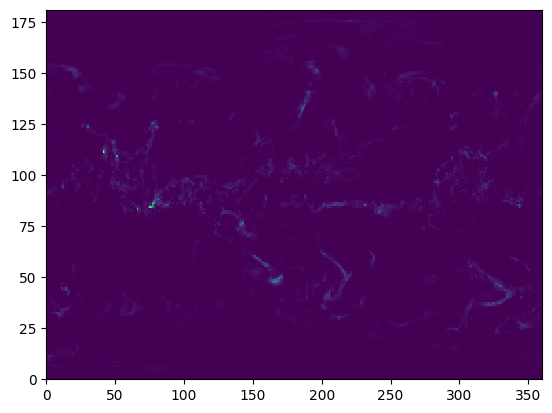

In [28]:
plt.pcolormesh(APCP)

In [29]:
APCP

array([[0.00576, 0.00576, 0.00576, ..., 0.00576, 0.00576, 0.00576],
       [0.02016, 0.02016, 0.02016, ..., 0.02016, 0.02016, 0.02016],
       [0.02304, 0.02304, 0.02304, ..., 0.02304, 0.02304, 0.02304],
       ...,
       [0.     , 0.     , 0.     , ..., 0.     , 0.     , 0.     ],
       [0.01152, 0.01152, 0.01152, ..., 0.01152, 0.01152, 0.01152],
       [0.06912, 0.06912, 0.06912, ..., 0.06912, 0.06912, 0.06912]],
      dtype=float32)

Community Earth System Model v2 Large Ensemble (CESM2 LENS)

https://gdex.ucar.edu/datasets/d010092/#

`/gdex/data/d651056/CESM2-LE/atm/proc/tseries/hour_6`

In [32]:
ds_gdas = ds_year

In [33]:
# ds_gdas = xr.open_dataset(save_name)

In [35]:
ds_ERA5 = xr.open_zarr('/glade/derecho/scratch/ksha/DWC_data/CONUS_domain_GP/dscale_1h/ERA5_GP_1h_2024.zarr')

In [45]:
Q_GDAS = ds_gdas['Q'].isel(time=1, level=0).values
Q_ERA5 = ds_ERA5['Q'].isel(time=6, level=0).values

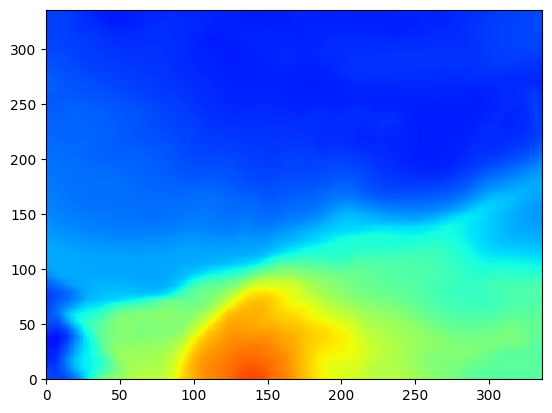

In [46]:
plt.pcolormesh(Q_ERA5, vmin=0, vmax=0.015, cmap=plt.cm.jet)

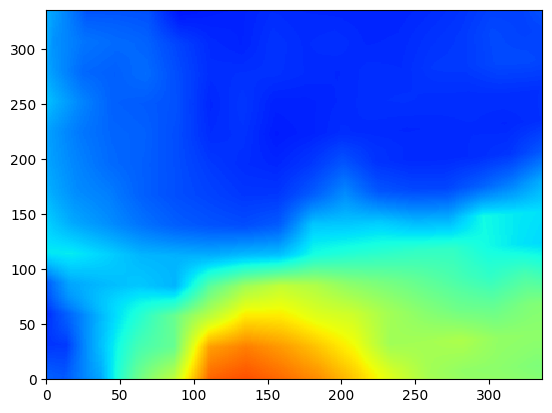

In [48]:
plt.pcolormesh(Q_GDAS, vmin=0, vmax=0.015, cmap=plt.cm.jet)

In [50]:
MSL_GDAS = ds_gdas['MSL'].isel(time=1,).values
MSL_ERA5 = ds_ERA5['MSL'].isel(time=6,).values

In [52]:
MSL_ERA5

array([[101886.016, 101886.   , 101886.03 , ..., 102240.66 , 102241.76 ,
        102243.   ],
       [101887.16 , 101887.63 , 101888.16 , ..., 102239.81 , 102240.89 ,
        102242.09 ],
       [101888.24 , 101889.22 , 101890.234, ..., 102238.95 , 102240.016,
        102241.17 ],
       ...,
       [102579.73 , 102581.586, 102583.42 , ..., 102190.945, 102185.15 ,
        102179.375],
       [102575.74 , 102577.54 , 102579.44 , ..., 102188.83 , 102182.93 ,
        102177.07 ],
       [102571.77 , 102573.48 , 102575.586, ..., 102186.68 , 102180.7  ,
        102174.74 ]], dtype=float32)

In [51]:
MSL_GDAS

array([[101872.01 , 101872.266, 101872.53 , ..., 102200.46 , 102201.14 ,
        102201.87 ],
       [101873.99 , 101874.266, 101874.55 , ..., 102199.83 , 102200.53 ,
        102201.29 ],
       [101875.97 , 101876.266, 101876.56 , ..., 102199.2  , 102199.93 ,
        102200.72 ],
       ...,
       [102602.125, 102618.22 , 102634.34 , ..., 102126.95 , 102120.93 ,
        102114.92 ],
       [102596.66 , 102613.   , 102629.38 , ..., 102124.32 , 102118.26 ,
        102112.21 ],
       [102591.15 , 102607.76 , 102624.516, ..., 102121.68 , 102115.58 ,
        102109.48 ]], dtype=float32)

In [42]:
T2_GDAS = ds_gdas['VAR_2T'].isel(time=1,).values
T2_ERA5 = ds_ERA5['VAR_2T'].isel(time=6,).values

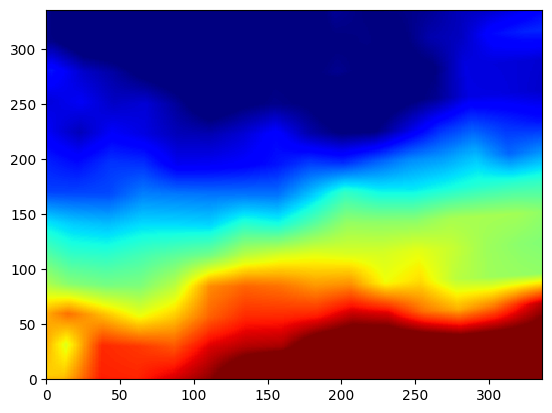

In [43]:
plt.pcolormesh(T2_GDAS, vmin=270, vmax=290, cmap=plt.cm.jet)

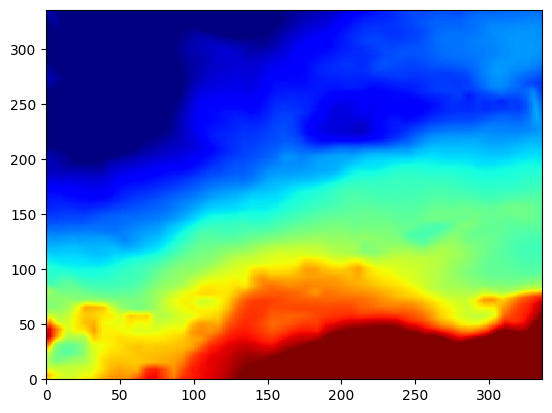

In [44]:
plt.pcolormesh(T2_ERA5, vmin=270, vmax=290, cmap=plt.cm.jet)

In [13]:
# import pygrib
# impport numpy as np

# # the title of grib variable names
# grb_names = [
#     'Pressure reduced to MSL:Pa (instant):regular_ll:meanSea:level 0',
#     '10 metre U wind component:m s**-1 (instant):regular_ll:heightAboveGround:level 10 m',
#     '10 metre V wind component:m s**-1 (instant):regular_ll:heightAboveGround:level 10 m',
# ]

# for p in 100*np.array([1000, 950, 850, 700, 600, 500, 400, 300, 200, 100, 50]):
#     grb_names += [
#         f'U component of wind:m s**-1 (instant):regular_ll:isobaricInhPa:level {p} Pa',
#         f'V component of wind:m s**-1 (instant):regular_ll:isobaricInhPa:level {p} Pa',
#         f'Temperature:K (instant):regular_ll:isobaricInhPa:level {p} Pa',
#         f'Relative humidity:% (instant):regular_ll:isobaricInhPa:level {p} Pa'
#     ]


# # grib2 file
# fn = '/gdex/data/d083002/grib2/2020/2020.01/fnl_20200101_00_00.grib2'
# grbs = pygrib.open(fn)

# # find the index of each variable name, pull variables, and save as an xr.dataset
# for grb in grbs:
#     print(grb)  # Prints information about each GRIB message